In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [14]:
#preparing gp data
all_sits_goal_data = pd.read_csv('csv_files/all_sits_player_goal_data.csv')
gp_df = all_sits_goal_data[['player', 'api_id', 'season_age', 'position', 
                            'position_type', 'team', 'season', 'session', 
                            'gp', 'toi']]

gp_df = gp_df.groupby(['player', 'api_id', 'season_age', 'position', 
                       'position_type', 'season', 'session', 'team'])[['gp', 'toi']].sum().reset_index()
'''
#prepating shift/shift length data
shift_data = pd.read_csv('large_files/player_shifts.csv')
player_pos = pd.read_csv('csv_files/player_positions.csv')
shift_data = shift_data.merge(player_pos, on='PLAYER_ID')
shift_data = shift_data[shift_data['POS'] != 'G']
#Still some really weird shifts in the data set filter out anything great than 250 seconds 
#which is over a 3 minute shift
shift_data = shift_data[shift_data['DURATION'] < 250]
shift_per_game_df = shift_data.groupby(['GAME_ID', 'PLAYER_ID', 'POS'])\
                    ['SHIFT_NUMBER'].max().reset_index()

shift_per_game_df = shift_per_game_df.rename(columns={'SHIFT_NUMBER':'shifts_in_game'})

#making all the column names lower case
shift_data.columns = list(map(str.lower, shift_data.columns))
player_pos.columns = list(map(str.lower, player_pos.columns))
shift_per_game_df.columns = list(map(str.lower, shift_per_game_df.columns))
gp_df.columns = list(map(str.lower, gp_df.columns))
all_sits_goal_data.columns = list(map(str.lower, all_sits_goal_data.columns))

#create a season column for shift data from game_id
shift_data['season'] = shift_data['game_id'].astype(str).str.slice(stop=4).astype(int) + 1
shift_per_game_df['season'] = shift_per_game_df['game_id'].astype(str).str.\
                              slice(stop=4).astype(int) + 1
shift_data['season'] = (shift_data['season'] - 1).astype(int).astype(str) + \
                          shift_data['season'].astype(int).astype(str)
shift_per_game_df['season'] = (shift_per_game_df['season'] - 1).astype(str) + \
                              shift_per_game_df['season'].astype(str)
'''
#get max possible games a player can play in a given season. It varies based on lockouts and
#the covid seasons
covid_season = gp_df[gp_df.season == 20192020].groupby(['team', 'season'])['gp'].max().reset_index()
gp_df = gp_df.merge(covid_season, how='left', on=['team', 'season'], suffixes=(None, '_y'))
gp_df = gp_df.rename(columns = {'gp_y': 'possible_gp'})
gp_df['possible_gp'] = np.where(gp_df['possible_gp'].isna(), 
                                np.where(gp_df['season'] == 20122013, 48, 82), 
                                gp_df['possible_gp'])

#create test/train sets
train_gp_df = gp_df[gp_df['season'] != 20192020]
test_gp_df = gp_df[gp_df['season'] == 20192020]
'''
train_shift_data = shift_data[shift_data['season'] != 20192020]
test_shift_data = shift_data[shift_data['season'] == 20192020]

#need to actually turn this into a shift per game dataframe
train_shift_per_game_df = shift_per_game_df[shift_per_game_df['season'] != 20192020]
test_shift_per_game_df = shift_per_game_df[shift_per_game_df['season'] == 20192020]
'''



"\ntrain_shift_data = shift_data[shift_data['season'] != 20192020]\ntest_shift_data = shift_data[shift_data['season'] == 20192020]\n\n#need to actually turn this into a shift per game dataframe\ntrain_shift_per_game_df = shift_per_game_df[shift_per_game_df['season'] != 20192020]\ntest_shift_per_game_df = shift_per_game_df[shift_per_game_df['season'] == 20192020]\n"

# Maybe don't scrap it yet maybe good to predict TOI still and feed that to the linear regression
# Scrap the Distribution for GP and just do the linear regression
# of TOI, GP, Season_age to next season GP
```
from sklearn.linear_model import LinearRegression
#x_train.head()
x_train['season_age'] = x_train['next_season_age'] - 1
reg = LinearRegression().fit(x_train[['toi', 'gp', 'season_age']], x_train[['gp_next']])
```

Use bagging regressor to bootstrap a CI of gp and then feed that into a model that uses current season TOI/GP to predict goals assists points. And then use that to then predict stuff. Maybe should look into fitting a bayesian regression.

previous toi, previous_points, season_age -> next gp -> next toi -> next goals

building a model to predict games played. then feed that into the regression that predicts TOI and then feed TOI into regression that predicts goals and assists. For forwards maybe put in iCF, iFF but they may correlate with TOI anyways

# Games Played Distributions

We're going to use the Binomial Distribution to model how many games a player plays in a season. The binomial takes 
two parameters $ n $ and $ p $. $ n $ is the number of trials we are looking for, in this case will be 82 since that's the number of games in the NHL regular season. While $ p $ is the probability of a player playing in each game. 

I picked the Beta Distribution as the prior for the distribution of $ p $ for the main reason that it is the conjugate prior of the Binomial Distribution. This makes the math much simpler and allows us to easily update our prior into a posterior distribution by simply adding the number of trials and sucesses to the parameters of our Beta prior.

Here is the formula for the Beta posterior:

$ \alpha + x $

$ \beta + N - x$

$ x $ is the number of successes and $ N $ is the number of trials. For the initial prior parameters we'll choose an $ \alpha $ and $ \beta $ that produces an expected value of the probability of playing 60 games a season which I think is reasonable for an average roster player on an NHL team. This means I will set $ \alpha = 60 $ and $ \beta = 22 $



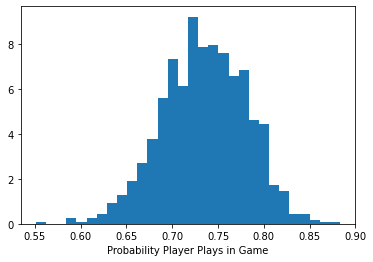

In [15]:
from scipy.stats import beta
# Showing the distribution of our initial prior beta distribution
r = beta.rvs(60, 22, size=1000)
plt.hist(r, density=True, histtype='stepfilled', bins=30)
plt.xlabel("Probability Player Plays in Game")
plt.show()

In [16]:
crosby_df = train_gp_df[train_gp_df.player == 'Sidney Crosby']
crosby_df = crosby_df.groupby(['player', 'api_id', 'position_type'])[['gp', 'possible_gp']].sum().reset_index()
crosby_df['possible_gp_not_played'] = crosby_df['possible_gp'] - crosby_df['gp']
crosby_df['posterior_alpha'] = 60 + crosby_df['gp']
crosby_df['posterior_beta'] = 22 + crosby_df['possible_gp'] - crosby_df['gp']
crosby_df

,player,api_id,position_type,gp,possible_gp,possible_gp_not_played,posterior_alpha,posterior_beta
0,Sidney Crosby,8471675,F,782.0,950.0,168.0,842.0,190.0


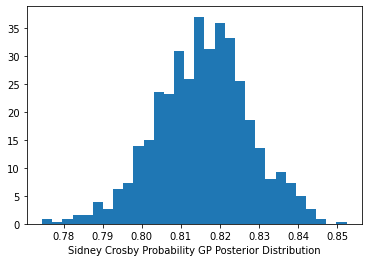

In [17]:
# Showing the distribution of our initial prior beta distribution
r = beta.rvs(crosby_df['posterior_alpha'].values, crosby_df['posterior_beta'].values, size=1000)
plt.hist(r, density=True, histtype='stepfilled', bins=30)
plt.xlabel("Sidney Crosby Probability GP Posterior Distribution")
plt.show()

As we can see from the graph of sampling from the update posterior distribution Sidney Crosby's most likely probability of playing a game is much higher than our prior. The data as updated our prior to reflect the evidence of the amount of games Crosby has played. We can calculate the mean and variance of our posterior distribution like so:

$ \large{\mu} = \LARGE{\frac{\alpha}{\alpha + \beta}} $

and for the variance:

$ \large{\sigma}^2 = \LARGE{\frac{\alpha\beta}{(\alpha + \beta)^2(\alpha + \beta + 1)}} $

Using these formulas we get that the mean probability that Sidney Crosby plays a game is ~ .81 and the variance is 0.0001. Taking the square root of the variance gives us a standard deviation ~ 0.012.

Now that we have our posterior distribution we can predict future values of games played using the Posterior predictive formula. Again since we used a conjugate prior this makes the math much simpler and it just reduces to the Beta Binomial distribution parameterized like this $ BetaBin(n, \alpha, \beta) $ where $ n $ is the number of games in a season.

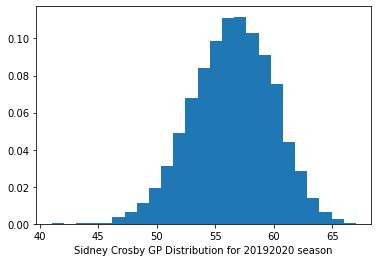

In [18]:
from scipy.stats import betabinom
r = betabinom.rvs(69, crosby_df['posterior_alpha'].values, crosby_df['posterior_beta'].values, size=10000)
plt.hist(r, density=True, bins=25)
plt.xlabel("Sidney Crosby GP Distribution for 20192020 season")
plt.show()

As we see in the distribution is Expected Value of GP in the 20192020 season was around 56 games. However he played 41 due to a core muscle surgery that kept him out six weeks. Despite his concussion issues from 20132014 on Crosby has been a fairly durable player. Its hard for the model to predict injuries for players who don't miss a lot of time. Possibly this could be adjusted by adding some sort of aging curve to players as they get older they are likely to play less games due to injury however at the extremes you will see some sort of survivorship bias as the players who are still playing at later ages probably are doing so because they've avoided injuries.


## Testing the Predictions of our GP Model

Now we need to see how our model does predicting GP for our test data set or the 20192020 NHL Season

In [19]:
train_gp_df = train_gp_df.groupby(['player', 'api_id', 'season_age', 'season', 'possible_gp'])\
              [['gp', 'toi']].sum().reset_index()
train_gp_df[train_gp_df.api_id == 8469534].head()

,player,api_id,season_age,season,possible_gp,gp,toi
14,Aaron Johnson,8469534,24.0,20072008,82.0,30.0,415.85
15,Aaron Johnson,8469534,25.0,20082009,82.0,38.0,537.38
16,Aaron Johnson,8469534,26.0,20092010,82.0,41.0,641.63
17,Aaron Johnson,8469534,28.0,20112012,82.0,56.0,924.40
18,Aaron Johnson,8469534,29.0,20122013,48.0,10.0,148.70


In [106]:
from scipy.stats import betabinom
players = list(train_gp_df.api_id.unique())
test_players = list(test_gp_df.api_id.unique())
seasons = list(train_gp_df.season.sort_values().unique())
predictions = []

for player in players:
   
    player_df = train_gp_df[train_gp_df.api_id == player]
    if player_df.shape[0] == 1 and player not in test_players:
        continue
    prior_alpha = 64
    prior_beta = 18
    posterior_alpha = 0
    posterior_beta = 0
    possible_games = 0
    previous_season = 0
    for i, season in enumerate(seasons):
        if season < player_df.season.min():
            continue
        if season > player_df.season.max():
            break
        if season not in player_df.season.values:
            continue
            
        season_df = player_df[player_df.season == season]
        
        if posterior_alpha == 0:
            posterior_alpha = prior_alpha + season_df['gp'].values[0]
            posterior_beta = prior_beta + season_df['possible_gp'].values[0] - season_df['gp'].values[0]
            previous_season = season_df['season'].values[0]
        else:
            missed_gp_add = 0
            if season_df.season.values[0] - previous_season != 10001:
                for i in range(((season_df.season.values[0] - previous_season)//10001)-1) :
                    if previous_season + ((i+1) * 10001) == 20122013:
                        missed_gp_add += 48
                    else:
                        missed_gp_add += 82
            #print(posterior_alpha, posterior_beta, season_df['possible_gp'].values[0])
            if season == 20122013:
                predicted_games = betabinom.rvs(48, posterior_alpha, posterior_beta, size=100).mean()
            else:
                predicted_games = betabinom.rvs(int(season_df['possible_gp'].values[0]), posterior_alpha, posterior_beta, size=100).max()
            predictions.append([player, season, predicted_games, season_df['gp'].values[0]])
            posterior_alpha += season_df['gp'].values[0]
            posterior_beta = posterior_beta + season_df['possible_gp'].values[0] + missed_gp_add - season_df['gp'].values[0]
            previous_season = season_df['season'].values[0]


In [107]:
predictions_df = pd.DataFrame(predictions, columns=['player', 'season','predicted', 'actual'])

from sklearn.metrics import r2_score, mean_absolute_error

print(r2_score(predictions_df[['actual']], predictions_df[['predicted']]))
print(mean_absolute_error(predictions_df['actual'], predictions_df['predicted']))


0.2008035857886611
17.194998783454988


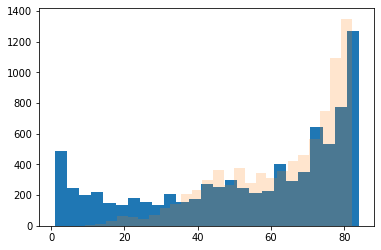

In [105]:
#alpha 66 beta 16
plt.hist(predictions_df['actual'], bins=25)
plt.hist(predictions_df['predicted'], bins=25, alpha=.4)
plt.show()

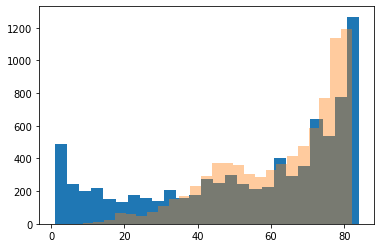

In [109]:
#alpha 64 beta 18
plt.hist(predictions_df['actual'], bins=25)
plt.hist(predictions_df['predicted'], bins=25, alpha=.4)
plt.show()

In [46]:
train_gp_df[train_gp_df.api_id == 8465992]

,player,api_id,season_age,season,possible_gp,gp,toi
3,Aaron Downey,8465992,33.0,20072008,82.0,56.0,256.93
4,Aaron Downey,8465992,34.0,20082009,82.0,4.0,20.83


In [50]:
prior_alpha = 30 + 56
prior_beta = 52 + 82 - 56
betabinom.rvs(82, posterior_alpha, posterior_beta, size=100).mean()

67.67

In [49]:
all_sits_goal_data[['toi', 'g', 'gp']].corr()

,toi,g,gp
toi,1.000000,0.649023,0.927694
g,0.649023,1.000000,0.651033
gp,0.927694,0.651033,1.000000


## Shifts in a Game Distribution

Now that we have a distribution of possible games for a player lets look at their distribution of shifts per game. I'm going to model this as a Poisson process where we are modeling the number of shits in a given time interval of a game. Again I will use bayesian inference to obtain a posterior and use a posterior predictive distribution to get a distribution of shifts in a game for the player.

For my prior im going to use the Gamma distribution which is another conjugate prior with parameters $ \alpha $ and $ \beta $ just like the Beta distribution. However in this instance $ \alpha $ represents the total occurances in $ \beta $ intervals. Since our interval is just one game we'll set $ \beta = 1 $ and im going to say that a player plays around 15 shifts a game so i'll set $ \alpha = 15 $.

To update our gamma prior we will use these formulas:

Alpha:

$ \large{\alpha + \sum_{i=1}^n k_i} $

Beta:

$ \large{\beta + {n}} $

So basically we are updating $ \alpha $ with the sum of our counts (or shifts) while we update $ \beta $ with the total number of observations. Let us repeat our earlier process for Crosby's games played but this time for shifts per game.

In [104]:
crosby_shift_per_game_df = train_shift_per_game_df[train_shift_per_game_df['player_id'] == 8471675]
crosby_shift_per_game_df = crosby_shift_per_game_df.groupby(['player_id', 'game_id'])['shift_number']\
                           .max().reset_index()
crosby_shift_per_game_df = crosby_shift_per_game_df.groupby('player_id')\
                           .agg({'shift_number': ['sum', 'count']}).reset_index()
crosby_shift_per_game_df.columns = crosby_shift_per_game_df.columns.to_flat_index().str.join('_')
crosby_shift_per_game_df['posterior_alpha'] = 20 + crosby_shift_per_game_df['shift_number_sum']
crosby_shift_per_game_df['posterior_beta'] = 1 + crosby_shift_per_game_df['shift_number_count']

,player_id_,shift_number_sum,shift_number_count,posterior_alpha,posterior_beta
0,8471675,21693,874,21713,875


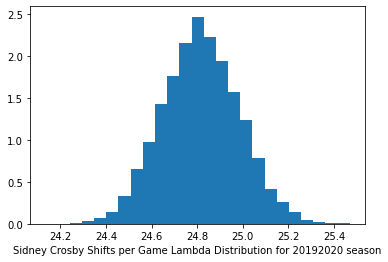

In [106]:
from scipy.stats import gamma
r = gamma.rvs(crosby_shift_per_game_df['posterior_alpha'].values, 
              scale=1/crosby_shift_per_game_df['posterior_beta'].values, size=10000)
plt.hist(r, density=True, bins=25)
plt.xlabel("Sidney Crosby Shifts per Game Lambda Distribution for 20192020 season")
plt.show()

For this our posterior predictive Distribution is the Negative Binomial paramaterized like this $ NB(\alpha, \frac{\beta}{\beta + 1}) $ 

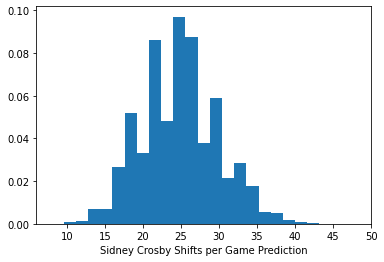

In [110]:
from scipy.stats import nbinom
r = nbinom.rvs(crosby_shift_per_game_df['posterior_alpha'].values,
               crosby_shift_per_game_df['posterior_beta'].values/(1 + crosby_shift_per_game_df['posterior_beta'].values), 
               size=10000)
plt.hist(r, density=True, bins=25)
plt.xlabel("Sidney Crosby Shifts per Game Prediction")
plt.show()

## Modeling Shift Length

Now that we have models for our games played in a season, and the shifts in a game, the next step is to model the length of the shifts themselves. For this I've chosen the Weibull Distribution as it is used to model the time to failure of an item. Here we are defining failure as when a player is forced to leave the ice at the end of his shift. I will just be using MLE estimate of the Weibull parameters given the data since generally most players play the same length of shift in a game.

In [184]:
# this takes a while to train
from scipy.stats import exponweib
results = exponweib.fit(train_shift_data['duration'], loc=0)

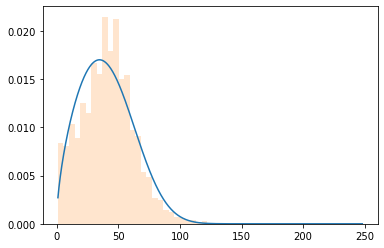

In [188]:
#plotting the distribution versus the data
x = np.linspace(train_shift_data['duration'].min(), train_shift_data['duration'].max(), 100000)
plt.plot(x, exponweib.pdf(x, *results))
plt.hist(train_shift_data['duration'], density=True, bins=55, alpha=.2)
plt.show()

In [21]:
train_shift_data['duration'].mean()

41.19147808630383

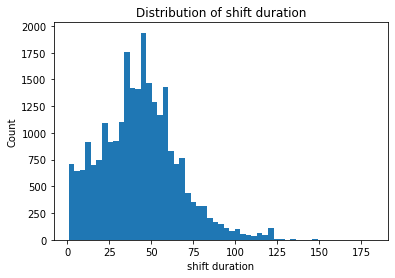

In [106]:
plt.hist(shift_data[shift_data.PLAYER_ID == 8471675]['DURATION'], bins=55)
plt.xlabel("shift duration")
plt.ylabel("Count")
plt.title("Distribution of shift duration")
plt.show()

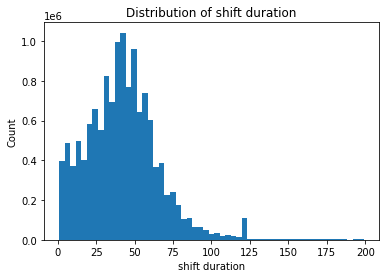

In [108]:
plt.hist(shift_data['DURATION'], bins=55)
plt.xlabel("shift duration")
plt.ylabel("Count")
plt.title("Distribution of shift duration")
plt.show()

In [119]:
print(shift_data[shift_data.player_id == 8476437]['duration'].mean())
print(shift_data[shift_data.player_id == 8471675]['duration'].mean())
print(shift_data['duration'].mean())
8471675

41.49249951295538
43.111989198204995
41.19349928591698


8471675

In [115]:
shift_count = shift_data[['PLAYER_ID', 'season', 'GAME_ID', 'DURATION']]\
              .groupby(['PLAYER_ID', 'season', 'GAME_ID'], as_index=False)\
              .count().rename(columns={'DURATION': 'num_of_shifts'})

In [118]:
shift_count.num_of_shifts.max()

209

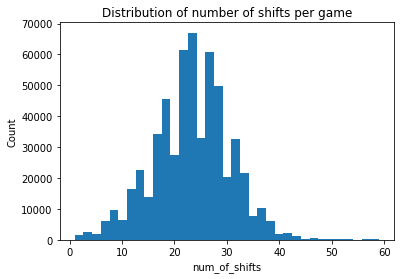

In [126]:
plt.hist(shift_count[(shift_data.PLAYER_ID == 8475178) & (shift_count.num_of_shifts < 60)]['num_of_shifts'], bins=20)
plt.xlabel("num_of_shifts")
plt.ylabel("Count")
plt.title("Distribution of number of shifts per game")
plt.show()

<ipython-input-127-0d2b47e1382b>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.hist(shift_count[(shift_data.PLAYER_ID == 8475178) & (shift_count.num_of_shifts < 60)]['num_of_shifts'], bins=20)


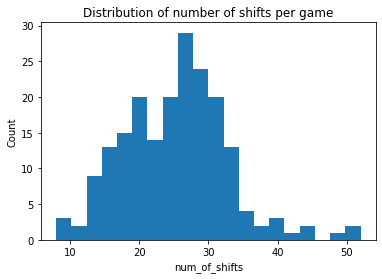

In [127]:
plt.hist(shift_count[(shift_data.PLAYER_ID == 8475178) & (shift_count.num_of_shifts < 60)]['num_of_shifts'], bins=20)
plt.xlabel("num_of_shifts")
plt.ylabel("Count")
plt.title("Distribution of number of shifts per game")
plt.show()

In [122]:
print(shift_count[(shift_data.PLAYER_ID == 8475178) & (shift_count.num_of_shifts < 60)]['num_of_shifts'].mean())
print(shift_count[(shift_count.num_of_shifts < 60)]['num_of_shifts'].mean())

<ipython-input-122-6b30910bd6a3>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(shift_count[(shift_data.PLAYER_ID == 8475178) & (shift_count.num_of_shifts < 60)]['num_of_shifts'].mean())


25.126903553299492
23.30448387039941


In [102]:
shift_data[(shift_data.PLAYER_ID == 8475178) & (shift_data.season == '2019')].DURATION.sum()/60

966.4666666666667

In [98]:
shift_data.GAME_ID.max()

2020030415

* Look at previous seasons goals correlation with current seasons shift count 
* for forwards previous season points and toi correlates decently with next season TOI
* for defense only really previous TOI maybe check plus minus

# Predicting Games Played
* GP is a poisson distribution with a truncated gamma conjugate prior and a negative binomial posterior predictive. The initial prior will be the gamma parameters that give an E[X] of 60 games.


In [130]:
sidney_df = all_sits_goal_data[all_sits_goal_data.player_upper == 'SIDNEY.CROSBY']
sidney_df.sort_values('season')

,player,player_upper,api_id,birthday,season_age,position,position_type,shoots,team,season,session,gp,toi,toi_gp,toi_perc,g,a1,a2,points,isf,iff,icf
814,Sidney Crosby,SIDNEY.CROSBY,8471675,1987-08-07,20.0,C,F,L,PIT,20072008,R,53.0,1104.78,20.84,34.26,24.0,33.0,15.0,72.0,173.0,233.0,280.0
1755,Sidney Crosby,SIDNEY.CROSBY,8471675,1987-08-07,21.0,C,F,L,PIT,20082009,R,77.0,1690.08,21.95,35.90,33.0,51.0,19.0,103.0,238.0,319.0,388.0
2713,Sidney Crosby,SIDNEY.CROSBY,8471675,1987-08-07,22.0,C,F,L,PIT,20092010,R,80.0,1756.55,21.96,36.07,51.0,36.0,22.0,109.0,291.0,393.0,490.0
3680,Sidney Crosby,SIDNEY.CROSBY,8471675,1987-08-07,23.0,C,F,L,PIT,20102011,R,41.0,898.62,21.92,36.09,32.0,20.0,14.0,66.0,161.0,219.0,278.0
4639,Sidney Crosby,SIDNEY.CROSBY,8471675,1987-08-07,24.0,C,F,L,PIT,20112012,R,22.0,406.38,18.47,30.53,8.0,16.0,13.0,37.0,75.0,97.0,126.0
5545,Sidney Crosby,SIDNEY.CROSBY,8471675,1987-08-07,25.0,C,F,L,PIT,20122013,R,36.0,759.75,21.10,34.96,15.0,28.0,13.0,56.0,124.0,168.0,203.0
6487,Sidney Crosby,SIDNEY.CROSBY,8471675,1987-08-07,26.0,C,F,L,PIT,20132014,R,80.0,1757.78,21.97,36.19,36.0,34.0,34.0,104.0,259.0,344.0,421.0
7442,Sidney Crosby,SIDNEY.CROSBY,8471675,1987-08-07,27.0,C,F,L,PIT,20142015,R,77.0,1538.37,19.98,32.76,28.0,31.0,25.0,84.0,237.0,315.0,380.0
8419,Sidney Crosby,SIDNEY.CROSBY,8471675,1987-08-07,28.0,C,F,L,PIT,20152016,R,80.0,1637.55,20.47,33.66,36.0,28.0,21.0,85.0,248.0,342.0,446.0
9368,Sidney Crosby,SIDNEY.CROSBY,8471675,1987-08-07,29.0,C,F,L,PIT,20162017,R,75.0,1490.83,19.88,32.66,44.0,28.0,17.0,89.0,255.0,325.0,411.0


In [135]:
prior_alpha = 10
prior_beta = .1666

posterior_predictive_sample = np.random.negative_binomial(prior_alpha + 53, 1/(1 + (prior_beta + 1)), size=1000)

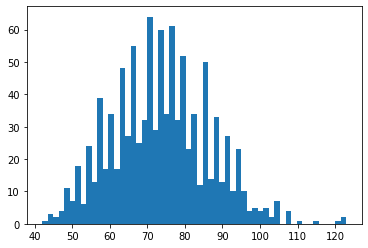

In [137]:
plt.hist(posterior_predictive_sample, bins=55)
plt.show()

In [134]:
test = np.empty(1)
print(test)

[310.80000003]


# Sources

[Intuition behind posterior predictive](https://stats.stackexchange.com/questions/438218/intuition-behind-posterior-predictive-distribution) Cross Validated

https://www.johndcook.com/blog/distributions_scipy/

https://ocw.mit.edu/courses/mathematics/18-05-introduction-to-probability-and-statistics-spring-2014/readings/MIT18_05S14_Reading15a.pdf